<a href="https://colab.research.google.com/github/precisionanalyst/My-first-repo/blob/main/Another_copy_of_Nystagmus_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load the video and extract frames for visualization

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt
from google.colab import files

# Upload the video from local directory
uploaded = files.upload()

# Take the video filename
video_path = list(uploaded.keys())[0]
cap = cv2.VideoCapture(video_path)

# Extract all frames
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

cap.release()

import random

# Decide on the number of frames to display (between 5 and 10)
num_display_frames = random.randint(5, 10)

# Randomly sample frames for display
display_frames = random.sample(frames, min(num_display_frames, len(frames)))

# Display the randomly sampled frames
fig, axes = plt.subplots(1, len(display_frames), figsize=(15, 5))
for ax, frame in zip(axes, display_frames):
    ax.imshow(frame)
    ax.axis("off")
plt.tight_layout()
plt.show()


# Step 2: Detect the eye in the initial frame

In [ ]:
!wget -nc https://github.com/anaustinbeing/haar-cascade-files/raw/b4c5af2e1393a29006ed3ae656caf9d021a0026a/haarcascade_eye.xml

--2023-10-06 12:06:07--  https://github.com/anaustinbeing/haar-cascade-files/raw/b4c5af2e1393a29006ed3ae656caf9d021a0026a/haarcascade_eye.xml
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/anaustinbeing/haar-cascade-files/b4c5af2e1393a29006ed3ae656caf9d021a0026a/haarcascade_eye.xml [following]
--2023-10-06 12:06:07--  https://raw.githubusercontent.com/anaustinbeing/haar-cascade-files/b4c5af2e1393a29006ed3ae656caf9d021a0026a/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341406 (333K) [text/plain]
Saving to: ‘haarcascade_eye.xml’

haarcascade_eye.xml 100%[===================

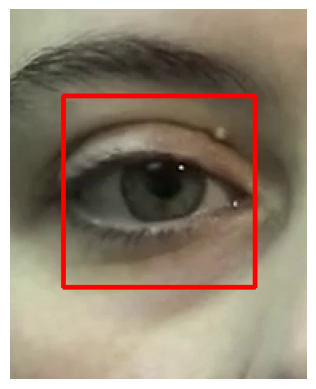

In [ ]:
# Load the Haar cascades for eye detection
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Detect eyes in the first frame
frame_0 = frames[0]
eyes = eye_cascade.detectMultiScale(frame_0, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around detected eyes
frame_0_with_detections = frame_0.copy()
for (x, y, w, h) in eyes:
    cv2.rectangle(frame_0_with_detections, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.imshow(frame_0_with_detections)
plt.axis('off')
plt.show()


# Step 3: Detect the pupil in the eye region:

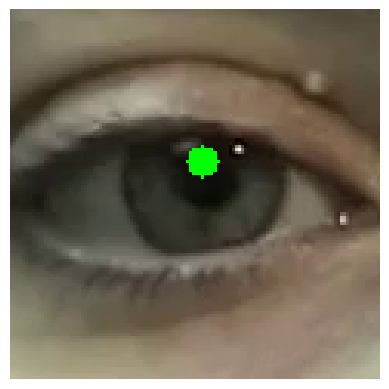

In [ ]:
def detect_pupil(eye_region):
    """
    Detect pupil in the given eye region.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(eye_region, cv2.COLOR_RGB2GRAY)

    # Use a binary threshold to segment the pupil
    _, thresholded = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If any contour is detected, choose the largest (assuming it corresponds to the pupil)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(max_contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0
        return (cx, cy)
    else:
        return None

# Extract the eye region from the first frame
(x, y, w, h) = eyes[0]
eye_region = frame_0[y:y+h, x:x+w]

# Detect the pupil in the eye region
pupil_center = detect_pupil(eye_region)

# Draw the pupil center on the eye region
eye_region_with_pupil = eye_region.copy()
if pupil_center:
    cv2.circle(eye_region_with_pupil, pupil_center, 5, (0, 255, 0), -1)

plt.imshow(eye_region_with_pupil)
plt.axis('off')
plt.show()


# Step 4: Track the pupil movement throughout the video

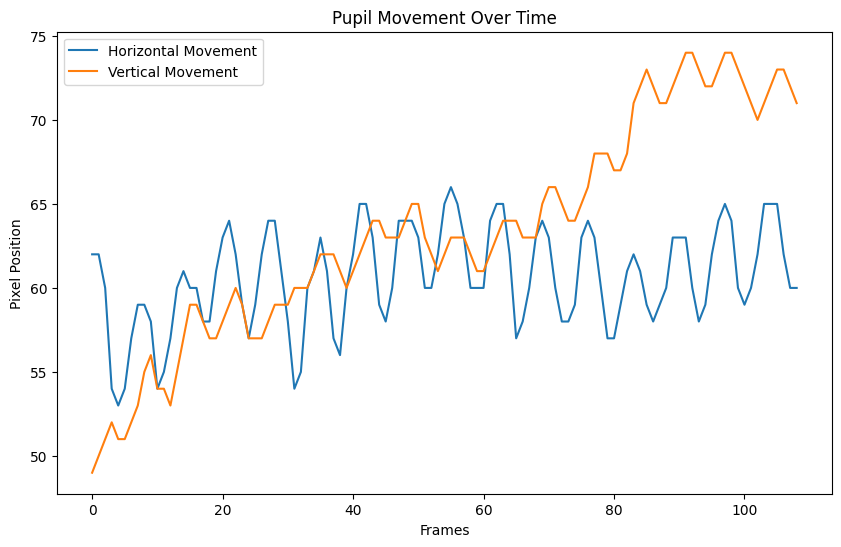

In [ ]:
cap = cv2.VideoCapture(video_path)

pupil_positions = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Extract the eye region using previously detected coordinates
    eye_region = frame_rgb[y:y+h, x:x+w]

    # Detect the pupil in the eye region
    pupil_center = detect_pupil(eye_region)

    if pupil_center:
        pupil_positions.append(pupil_center)
    else:
        # If not detected, use the last known position
        pupil_positions.append(pupil_positions[-1] if pupil_positions else (w//2, h//2))

cap.release()

# Plot the movement of the pupil
x_positions, y_positions = zip(*pupil_positions)
plt.figure(figsize=(10, 6))
plt.plot(x_positions, label="Horizontal Movement")
plt.plot(y_positions, label="Vertical Movement")
plt.title("Pupil Movement Over Time")
plt.xlabel("Frames")
plt.ylabel("Pixel Position")
plt.legend()
plt.show()


# Step 5: To Anaylze the Type of Nystagmus
Pendular nystagmus is characterized by smooth, rhythmic oscillations of the eyes, typically of equal speed in both directions. The oscillations can be horizontal, vertical, or even rotary. In this case, the pronounced rhythmic oscillation in the horizontal movement, as observed in the plots.

**Pendular Nystagmus:**
Characterized by smooth, rhythmic oscillations of the eyes, typically of equal speed in both directions (like a pendulum). This seems to be the most likely type given the observed rhythmic behavior in the horizontal movement.

**Jerk Nystagmus:**
The eyes drift slowly in one direction, then "jerk" quickly in the opposite direction. This type would have shown a clear pattern of slow drifts followed by quick movements, which doesn't seem to be the primary behavior in the plots.

**Rotary/Torsional Nystagmus:**
The eyes rotate or twist about the visual axis. This type is difficult to determine since they focus on horizontal and vertical movements.

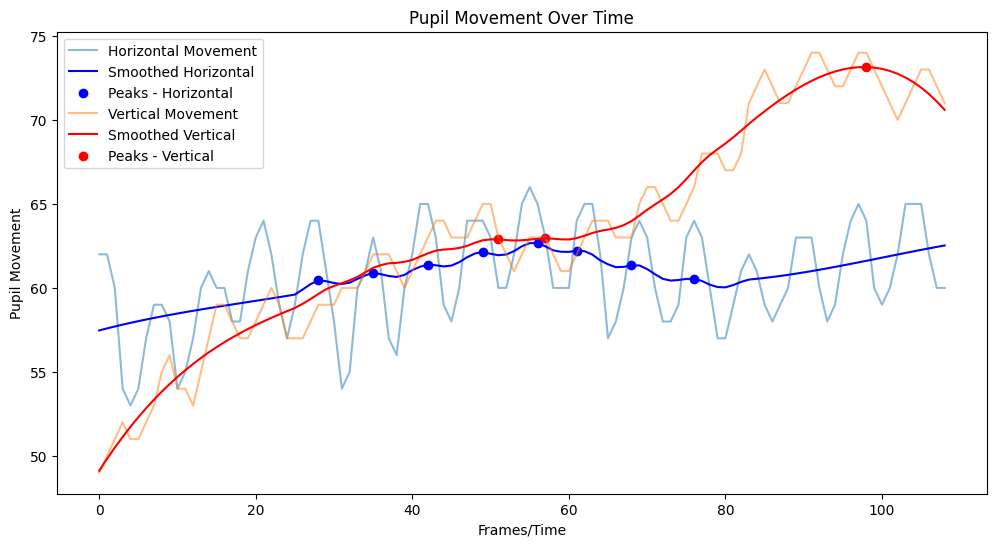


Based on the provided analysis, the detected nystagmus type is: Pendular Nystagmus
Average Amplitude - Horizontal: 60.63
Average Amplitude - Vertical: 63.38
Average Frequency - Horizontal: 0.07 peaks per frame
Average Frequency - Vertical: 0.03 peaks per frame


In [ ]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# Assuming you've already defined the `x_positions` and `y_positions` arrays from previous steps

# 1. SMOOTHING USING THE SAVITZKY-GOLAY FILTER
# ----------------------------------------------
# The Savitzky-Golay filter helps in smoothing data. It fits a polynomial of a
# specific order (in this case, 3) to a sliding window (in this case, 51 frames)
# of the data.

# Smoothing the horizontal data (e.g., x-axis movement of the pupil)
smoothed_horizontal = savgol_filter(x_positions, window_length=51, polyorder=3)

# Smoothing the vertical data (e.g., y-axis movement of the pupil)
smoothed_vertical = savgol_filter(y_positions, window_length=51, polyorder=3)


# 2. HIGHLIGHTING PEAKS
# ---------------------
# The `find_peaks` function identifies peaks in the data, which can be indicative
# of rapid changes in pupil position (e.g., saccades or nystagmus beats).

# Find peaks in the smoothed horizontal data
peaks_horizontal, _ = find_peaks(smoothed_horizontal)

# Find peaks in the smoothed vertical data
peaks_vertical, _ = find_peaks(smoothed_vertical)


# 3. PLOTTING THE DATA
# --------------------
# This section creates a visual representation of the original and smoothed data,
# and highlights the peaks.

# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Plot the original horizontal movement data
plt.plot(x_positions, label='Horizontal Movement', alpha=0.5)

# Plot the smoothed horizontal movement data
plt.plot(smoothed_horizontal, label='Smoothed Horizontal', color='blue')

# Highlight the peaks in the horizontal data
plt.scatter(peaks_horizontal, smoothed_horizontal[peaks_horizontal], color='blue', marker='o', label='Peaks - Horizontal')

# Plot the original vertical movement data
plt.plot(y_positions, label='Vertical Movement', alpha=0.5)

# Plot the smoothed vertical movement data
plt.plot(smoothed_vertical, label='Smoothed Vertical', color='red')

# Highlight the peaks in the vertical data
plt.scatter(peaks_vertical, smoothed_vertical[peaks_vertical], color='red', marker='o', label='Peaks - Vertical')

# Add labels, title, and legend to the plot
plt.legend()
plt.xlabel('Frames/Time')
plt.ylabel('Pupil Movement')
plt.title('Pupil Movement Over Time')
plt.show()


# 4. COMPUTING METRICS
# --------------------
# This section computes metrics that might be indicative of the type and
# characteristics of nystagmus.

# Calculate average amplitude for horizontal and vertical movement
avg_amplitude_horizontal = np.mean(smoothed_horizontal)
avg_amplitude_vertical = np.mean(smoothed_vertical)

# Calculate average frequency of peaks for horizontal and vertical movement
avg_frequency_horizontal = len(peaks_horizontal) / len(x_positions)
avg_frequency_vertical = len(peaks_vertical) / len(y_positions)

# Check for type of nystagmus based on frequency of peaks
# The threshold is set at 0.05 peaks per frame, but can be adjusted based on domain knowledge
threshold_frequency = 0.05
if avg_frequency_horizontal > threshold_frequency or avg_frequency_vertical > threshold_frequency:
    nystagmus_type = "Pendular Nystagmus"
else:
    nystagmus_type = "Unknown or No Clear Nystagmus Pattern"

# Print the results
print(f"\nBased on the provided analysis, the detected nystagmus type is: {nystagmus_type}")
print(f"Average Amplitude - Horizontal: {avg_amplitude_horizontal:.2f}")
print(f"Average Amplitude - Vertical: {avg_amplitude_vertical:.2f}")
print(f"Average Frequency - Horizontal: {avg_frequency_horizontal:.2f} peaks per frame")
print(f"Average Frequency - Vertical: {avg_frequency_vertical:.2f} peaks per frame")


# Pupil Movement Trajectory

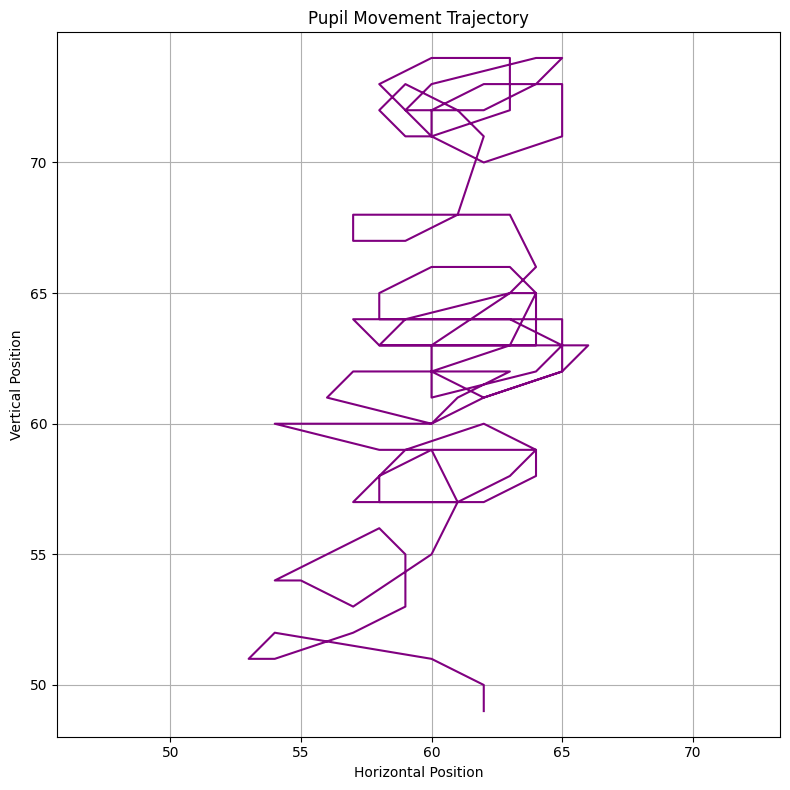

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_positions and y_positions are your pupil movement data arrays

# Plotting the trajectory of the pupil movements
plt.figure(figsize=(8, 8))

# Plotting x_positions against y_positions to show the trajectory
plt.plot(x_positions, y_positions, label="Pupil Trajectory", color='purple')
plt.title("Pupil Movement Trajectory")
plt.xlabel("Horizontal Position")
plt.ylabel("Vertical Position")
plt.grid(True)
plt.axis('equal')  # This ensures the scale is the same on both axes for accurate representation

plt.tight_layout()
plt.show()


# Pupil Movement Waveform Over Time

In [ ]:
import numpy as np
import plotly.express as px

def plot_combined_waveform(x_positions, y_positions):
    # Data validation
    if len(x_positions) != len(y_positions) or not isinstance(x_positions, np.ndarray) or not isinstance(y_positions, np.ndarray):
        raise ValueError("x_positions and y_positions must be valid NumPy arrays with the same length.")

    # Calculate the average of horizontal and vertical movements
    combined_waveform = (x_positions + y_positions) / 2

    # Create a time array based on the length of your data
    time = np.arange(len(combined_waveform))

    # Create a DataFrame with time and combined_waveform data
    import pandas as pd
    df = pd.DataFrame({'Time': time, 'Combined_Waveform': combined_waveform})

    # Create an interactive plot using Plotly Express
    fig = px.line(df, x='Time', y='Combined_Waveform', title='Combined (x and y) Pupil Movement Waveform Over Time',
                  labels={'Combined_Waveform': 'Position'})
    fig.update_traces(line=dict(color='purple'), marker=dict(size=3))

    # Center the title
    fig.update_layout(title_x=0.5)  # Set title_x to 0.5 for center alignment

    # Show the plot
    fig.show()

# Example usage
x_positions = np.array(x_positions)
y_positions = np.array(y_positions)
plot_combined_waveform(x_positions, y_positions)


# Vertical & Horizontal Eye Movements Over Time

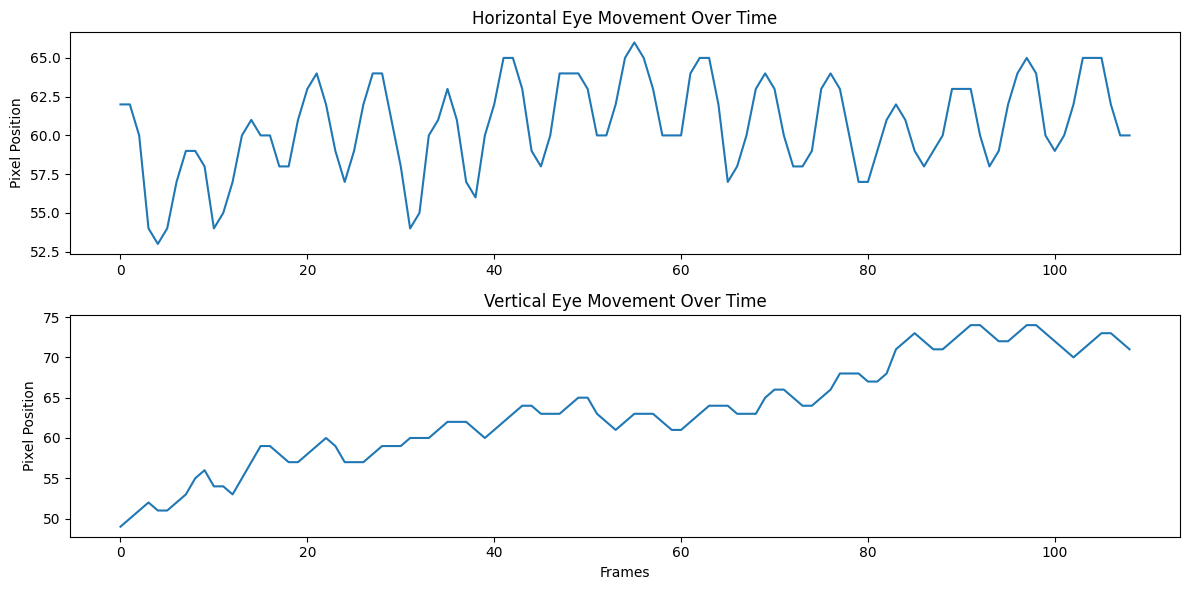

In [ ]:
# Plotting the horizontal and vertical movements

plt.figure(figsize=(12, 6))

# Horizontal movement plot
plt.subplot(2, 1, 1)
plt.plot(x_positions, label="Horizontal Movement")
plt.title("Horizontal Eye Movement Over Time")
plt.ylabel("Pixel Position")

# Vertical movement plot
plt.subplot(2, 1, 2)
plt.plot(y_positions, label="Vertical Movement")
plt.title("Vertical Eye Movement Over Time")
plt.xlabel("Frames")
plt.ylabel("Pixel Position")

plt.tight_layout()
plt.show()
